In [21]:
import numpy as np

#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code. 
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras

os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow
#We can also set it to Theano if we want. 


#Iterate through all images in Parasitized folder, resize to 64 x 64
#Then save as numpy array with name 'dataset'
#Set the label to this as 0

image_directory = 'cell_images/cell_images/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

In [22]:


#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)


#Apply CNN
# ### Build the model

#############################################################
###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)

conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)

hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model1 = keras.Model(inputs=inp, outputs=out)
model1.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model1.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0   

In [23]:
    
###############################################################    
    
 ### Split the dataset
# 
# I split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

# When training with Keras's Model.fit(), adding the tf.keras.callback.TensorBoard callback 
# ensures that logs are created and stored. Additionally, enable histogram computation 
#every epoch with histogram_freq=1 (this is off by default)
#Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

#import datetime

#log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "/"
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# ### Training the model
# As the training data is now ready, I will use it to train the model.   

#Fit the model

In [24]:

# history = model.fit(np.array(X_train), 
#                          y_train, 
#                          verbose = 1, 
#                          epochs = 2,      #Changed to 3 from 50 for testing purposes.
#                          validation_split = ,
#                          shuffle = False
#                       #   callbacks=callbacks
#                      )
# X_train = np.array(X_train)
# history = model.train_on_batch(X_train[:128],y_train[:128])

from datetime import datetime
print(datetime.now())

2022-05-10 02:16:33.260548


In [25]:
import math
# Train
train_error_hist1 = list()
test_error_hist1 = list()
test_acc_hist1 = list()
batch_size = 64
itr = 0

savepath = 'origCNNpath'

scaled_x_train = np.array(X_train)
scaled_x_test = np.array(X_test)
n_batches = math.ceil(len(scaled_x_train) / batch_size)
best_acc = 0
while itr < 2:
    for i in range(n_batches):
        X_batch = scaled_x_train[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]
#         print(i)
#         print(len(y_batch[y_batch==1]))
    
        loss = model1.train_on_batch(X_batch, y_batch)
        train_error_hist1.append(loss[0])
        loss1 = model1.test_on_batch(scaled_x_test, y_test)
        print(i, loss1[1])
#         test_error_hist.append(loss1[0])
#         test_acc_hist.append(loss1[1])
#     if itr%5==0:
#         print(itr)
        if best_acc < loss1[1]:
            best_acc = loss1[1]
            model1.save(savepath) # saves compiled state
            best_model = keras.models.load_model(savepath)
            
        test_error_hist1.append(loss1[0])
        test_acc_hist1.append(loss1[1])
    itr = itr+1

# model.fit(x=scaled_x_train, y=y_train, epochs=iterations, validation_split=validation_split, batch_size=batch_size)



0 0.5816400647163391
INFO:tensorflow:Assets written to: origCNNpath\assets
1 0.538642942905426
2 0.5161466002464294
3 0.512699544429779
4 0.5125181674957275
5 0.5116110444068909
6 0.5123367309570312
7 0.5117924809455872
8 0.5134252309799194
9 0.5156023502349854
10 0.5186864733695984
11 0.5203192830085754
12 0.5228592157363892
13 0.5243105888366699
14 0.5252177119255066
15 0.5235849022865295
16 0.5214078426361084
17 0.5201379060745239
18 0.5175979733467102
19 0.5172351002693176
20 0.5166908502578735
21 0.5132438540458679
22 0.511066734790802
23 0.5101596713066101
24 0.5097967982292175
25 0.5097967982292175
26 0.5097967982292175
27 0.5099782347679138
28 0.5099782347679138
29 0.5097967982292175
30 0.5097967982292175
31 0.5097967982292175
32 0.5096153616905212
33 0.5096153616905212
34 0.5096153616905212
35 0.5096153616905212
36 0.5097967982292175
37 0.5099782347679138
38 0.5101596713066101
39 0.5101596713066101
40 0.5101596713066101
41 0.5103410482406616
42 0.5105224847793579
43 0.51052248

330 0.7354862093925476
331 0.7169811129570007
332 0.6914005875587463
333 0.664731502532959
334 0.6556603908538818
335 0.6529390215873718
336 0.6536647081375122
337 0.6701741814613342
338 0.6899492144584656
339 0.7148040533065796
340 0.7287735939025879
341 0.7594339847564697
INFO:tensorflow:Assets written to: origCNNpath\assets
342 0.7750362753868103
INFO:tensorflow:Assets written to: origCNNpath\assets
343 0.775943398475647
INFO:tensorflow:Assets written to: origCNNpath\assets
344 0.7855587601661682
INFO:tensorflow:Assets written to: origCNNpath\assets
0 0.7899129390716553
INFO:tensorflow:Assets written to: origCNNpath\assets
1 0.7793903946876526
2 0.7882801294326782
3 0.7949927449226379
INFO:tensorflow:Assets written to: origCNNpath\assets
4 0.7977140545845032
INFO:tensorflow:Assets written to: origCNNpath\assets
5 0.7969883680343628
6 0.8002539873123169
INFO:tensorflow:Assets written to: origCNNpath\assets
7 0.7984397411346436
8 0.8116835951805115
INFO:tensorflow:Assets written to: o

301 0.8737300634384155
302 0.8793541193008423
303 0.8809869289398193
304 0.8849782347679138
305 0.8904209136962891
306 0.8993105888366699
307 0.9065675139427185
INFO:tensorflow:Assets written to: origCNNpath\assets
308 0.9085631370544434
INFO:tensorflow:Assets written to: origCNNpath\assets
309 0.9103773832321167
INFO:tensorflow:Assets written to: origCNNpath\assets
310 0.9098330736160278
311 0.9020319581031799
312 0.8947750329971313
313 0.8920537233352661
314 0.8925979733467102
315 0.8955007195472717
316 0.9022133350372314
317 0.9127358198165894
INFO:tensorflow:Assets written to: origCNNpath\assets
318 0.9149129390716553
INFO:tensorflow:Assets written to: origCNNpath\assets
319 0.913642942905426
320 0.9161828756332397
INFO:tensorflow:Assets written to: origCNNpath\assets
321 0.914731502532959
322 0.913642942905426
323 0.9085631370544434
324 0.9033018946647644
325 0.895682156085968
326 0.8913280367851257
327 0.8875181674957275
328 0.8815311789512634
329 0.8815311789512634
330 0.8802612

In [26]:

print(datetime.now())

2022-05-10 03:02:31.016841


In [27]:

# ## Accuracy calculation
# 
# I'll now calculate the accuracy on the test data.

# print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))




# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# t = f.suptitle('CNN Performance', fontsize=12)
# f.subplots_adjust(top=0.85, wspace=0.3)

# max_epoch = len(history.history['accuracy'])+1
# epoch_list = list(range(1,max_epoch))

# ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
# ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
# ax1.set_xticks(np.arange(1, max_epoch, 5))
# ax1.set_ylabel('Accuracy Value')
# ax1.set_xlabel('Epoch')
# ax1.set_title('Accuracy')
# l1 = ax1.legend(loc="best")

# ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
# ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
# ax2.set_xticks(np.arange(1, max_epoch, 5))
# ax2.set_ylabel('Loss Value')
# ax2.set_xlabel('Epoch')
# ax2.set_title('Loss')
# l2 = ax2.legend(loc="best")


#Save the model
# model.save('malaria_cnn.h5')

################################################
### ANOTHER WAY TO DEFINE THE NETWORK using Sequential model
#Sequential 
#You can create a Sequential model by passing a list of layer instances to the constructor:
"""
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
model = None
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(activation = 'relu', units=512))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))
model.add(Dense(activation = 'sigmoid', units=2))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())
"""

'\nfrom keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout\nfrom keras.models import Sequential\nmodel = None\nmodel = Sequential()\nmodel.add(Convolution2D(32, (3, 3), input_shape = (SIZE, SIZE, 3), activation = \'relu\', data_format=\'channels_last\'))\nmodel.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))\nmodel.add(BatchNormalization(axis = -1))\nmodel.add(Dropout(0.2))\nmodel.add(Convolution2D(32, (3, 3), activation = \'relu\'))\nmodel.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))\nmodel.add(BatchNormalization(axis = -1))\nmodel.add(Dropout(0.2))\nmodel.add(Flatten())\nmodel.add(Dense(activation = \'relu\', units=512))\nmodel.add(BatchNormalization(axis = -1))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(activation = \'relu\', units=256))\nmodel.add(BatchNormalization(axis = -1))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(activation = \'sigmoid\', units=2))\nmodel.compile(optimizer = \'adam\', loss = \'c

In [53]:
test_as =[0.5097968, 0.51560235, 0.5137881, 0.49292454, 0.49056605, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.4903846, 0.49056605, 0.5043541, 0.56277215, 0.58907837, 0.5950653, 0.6092163, 0.62282294, 0.6264514, 0.63497823, 0.6415094, 0.6436865, 0.63661104, 0.6337083, 0.63733673, 0.6396952, 0.6427794, 0.6097605, 0.5734761, 0.5527939, 0.5390058, 0.53211176, 0.52884614, 0.52467346, 0.5215893, 0.5243106, 0.5252177, 0.53120464, 0.5446299, 0.5573295, 0.5703919, 0.5861756, 0.6103048, 0.6246371, 0.64132804, 0.65039915, 0.6574746, 0.65039915, 0.6387881, 0.62373006, 0.61973876, 0.6171988, 0.6317126, 0.63933235, 0.64985484, 0.65620464, 0.66527575, 0.670537, 0.6627358, 0.63824385, 0.607402, 0.5789187, 0.56313497, 0.55007255, 0.53864294, 0.5283019, 0.52376634, 0.5177794, 0.5146952, 0.51269954, 0.51197386, 0.5107039, 0.51034105, 0.5105225, 0.51106673, 0.5101597, 0.5101597, 0.5101597, 0.5101597, 0.51034105, 0.51034105, 0.5107039, 0.51088536, 0.51106673, 0.51088536, 0.5114296, 0.51197386, 0.51233673, 0.51324385, 0.5137881, 0.51396954, 0.51324385, 0.51251817, 0.51197386, 0.5114296, 0.51161104, 0.5114296, 0.51161104, 0.5117925, 0.51233673, 0.51360667, 0.5146952, 0.5157837, 0.5170537, 0.51977503, 0.52140784, 0.5228592, 0.5239478, 0.5252177, 0.5266691, 0.52812046, 0.5319303, 0.53320026, 0.53519595, 0.53719157, 0.5380987, 0.53755444, 0.54227144, 0.5462627, 0.55315673, 0.5542453, 0.5558781, 0.55714804, 0.558418, 0.5600508, 0.55478954, 0.54934686, 0.54735124, 0.54535556, 0.54426706, 0.54426706, 0.5435414, 0.54589987, 0.55007255, 0.55914366, 0.56513065, 0.5740203, 0.58472425, 0.59143686, 0.6044993, 0.6309869, 0.6627358, 0.67271405, 0.66999274, 0.6560232, 0.6217344, 0.59923804, 0.5738389, 0.5538824, 0.5440856, 0.54100144, 0.53211176, 0.52140784, 0.51832366, 0.51832366, 0.51832366, 0.51904935, 0.5203193, 0.5219521, 0.5259434, 0.53519595, 0.54227144, 0.5522496, 0.57021046, 0.595791, 0.6175617, 0.64096516, 0.67035556, 0.68940496, 0.6785196, 0.6650943, 0.6411466, 0.63026124, 0.6195573, 0.60522497, 0.5947025, 0.58798987, 0.57928157, 0.5691219, 0.5687591, 0.570029, 0.55714804, 0.5522496, 0.5440856, 0.53447026, 0.5308418, 0.52703196, 0.52485484, 0.52467346, 0.52340347, 0.5221335, 0.5215893, 0.52140784, 0.5208636, 0.52104497, 0.5203193, 0.5205007, 0.5243106, 0.52775764, 0.53283745, 0.5393686, 0.5478955, 0.55714804, 0.5647678, 0.57764876, 0.5930697, 0.60758346, 0.6191945, 0.61465895, 0.60431784, 0.5963353, 0.59796804, 0.5981495, 0.5947025, 0.57910013, 0.5720247, 0.5673077, 0.56150216, 0.55914366, 0.56186503, 0.56513065, 0.5683962, 0.57166183, 0.56621915, 0.56349784, 0.559688, 0.5593251, 0.558418, 0.5569666, 0.55170536, 0.5488026, 0.54571843, 0.5446299, 0.54082, 0.5415457, 0.5429971, 0.54589987, 0.54934686, 0.5569666, 0.5649492, 0.5856314, 0.61411464, 0.64404935, 0.6391509, 0.61810595, 0.5947025, 0.58817124, 0.5801887, 0.57801163, 0.5754717, 0.57293177, 0.57438314, 0.56458634, 0.5527939, 0.5353774, 0.527939, 0.52539915, 0.52340347, 0.52340347, 0.5235849, 0.52467346, 0.52539915, 0.5283019, 0.5293904, 0.5313861, 0.5333817, 0.537373, 0.5393686, 0.5440856, 0.55333817, 0.55678517, 0.5624093, 0.56694484, 0.56204647, 0.56585634, 0.55478954, 0.5446299, 0.5406386, 0.53519595, 0.53682876, 0.5431785, 0.53755444, 0.54263425, 0.54970974, 0.55406386, 0.57093614, 0.5787373, 0.58653843, 0.58635706, 0.58581275, 0.58708274, 0.5869013, 0.5820029, 0.58073294, 0.5769231, 0.5667634, 0.5607765, 0.5551524, 0.55061686, 0.5411829, 0.5350145, 0.5293904, 0.52539915, 0.5228592, 0.5188679, 0.5165094, 0.5145138, 0.51560235, 0.5152395, 0.51324385, 0.5137881, 0.5157837, 0.5172351, 0.51632804, 0.51596516, 0.5152395, 0.5146952, 0.51505804, 0.51560235, 0.5157837, 0.51669085, 0.5157837, 0.5165094, 0.51560235, 0.5168723, 0.5179608, 0.5170537, 0.51596516, 0.51669085, 0.5170537, 0.5179608, 0.51832366, 0.5179608, 0.5186865, 0.5186865, 0.5192308, 0.51977503, 0.52068216, 0.5208636, 0.5212264, 0.5219521, 0.5243106, 0.5255805, 0.527939, 0.5299347, 0.5306604, 0.52775764, 0.52340347, 0.5177794, 0.5117925, 0.50925255, 0.50961536, 0.509434, 0.50961536, 0.50961536, 0.5090711, 0.5067126, 0.49782294, 0.48149493, 0.46571118, 0.44285196, 0.433418, 0.42071843, 0.41273585, 0.42670536, 0.44938317, 0.46480405, 0.48076922, 0.51088536, 0.58236575, 0.6445936, 0.67870104, 0.7109942, 0.7314949, 0.7345791, 0.7425617, 0.75290275, 0.75616837, 0.76632804, 0.77957183, 0.7864659, 0.78701013, 0.77177066, 0.73639333, 0.6899492, 0.6320755, 0.5812772, 0.5560595, 0.5306604, 0.51342523, 0.5243106, 0.5582366, 0.59724236, 0.64731497, 0.71716255, 0.7692308, 0.7986212, 0.8240203, 0.8318215, 0.8361756, 0.83871555, 0.83635706, 0.83635706, 0.83000726, 0.8271045, 0.82492745, 0.81694484, 0.81440496, 0.79589987, 0.7668723, 0.73439765, 0.6785196, 0.6435051, 0.62137157, 0.6144775, 0.6347968, 0.6788824, 0.75108856, 0.81386065, 0.8407112, 0.8383527, 0.83798987, 0.820029, 0.7888244, 0.72224236, 0.62209725, 0.55079824, 0.51560235, 0.51596516, 0.51977503, 0.52485484, 0.532656, 0.5560595, 0.5966981, 0.69793177, 0.7743106, 0.8352685, 0.85903484, 0.8710087, 0.8813498, 0.8829826, 0.88497823, 0.8809869, 0.884434, 0.83544993, 0.8254717, 0.8419811, 0.86738026, 0.88588536, 0.79499274, 0.53610307, 0.50380987, 0.5063498, 0.509434, 0.51505804, 0.5290276, 0.5703919, 0.62753993, 0.70174164, 0.7842888, 0.82529026, 0.8564949, 0.87753993, 0.8867925, 0.8993106, 0.90475327, 0.9069303, 0.9067489, 0.9060232, 0.9065675, 0.89876634, 0.8847968, 0.8612119, 0.83653843, 0.816582, 0.7998912, 0.77467346, 0.77068216, 0.77376634, 0.78356314, 0.8140421, 0.8434325, 0.8604862, 0.88189405, 0.89132804, 0.8942308, 0.89060235, 0.8898766, 0.89967346, 0.91364294, 0.9150943, 0.9143686, 0.91582, 0.9150943, 0.9143686, 0.912373, 0.91128445, 0.91219157, 0.91255444, 0.912373, 0.9138244, 0.9147315, 0.91291726, 0.91582, 0.9167271, 0.9178157, 0.91727144, 0.91727144, 0.91709, 0.91690856, 0.9156386, 0.91582, 0.9156386, 0.9147315, 0.91455007, 0.9154572, 0.91709, 0.9190856, 0.9201742, 0.9214441, 0.92235124, 0.92271405, 0.9230769, 0.9228955, 0.9241654, 0.9241654, 0.9238026, 0.921807, 0.9190856, 0.91092163, 0.9040276, 0.89731497, 0.8935051, 0.8855225, 0.88534105, 0.88189405, 0.8867925, 0.8915094, 0.89912915, 0.9036647, 0.90820026, 0.9103774, 0.9132801, 0.9147315, 0.9163643, 0.9187228, 0.92198837, 0.92325836, 0.9225327, 0.92325836, 0.92198837, 0.92089987, 0.9181785, 0.9174528, 0.91182876, 0.9083817, 0.90820026, 0.9058418, 0.9040276, 0.9033019, 0.90312046, 0.9018505, 0.90221334, 0.9016691, 0.8971335, 0.8942308, 0.8902395, 0.8898766, 0.8911466, 0.8918723, 0.89495647, 0.89985484, 0.90457183, 0.907656, 0.9060232, 0.9058418, 0.90457183, 0.90348333, 0.90457183, 0.90112484, 0.8962264, 0.89060235, 0.88588536, 0.883164, 0.8777213, 0.8735486, 0.87318575, 0.8733672, 0.87391144, 0.8740929, 0.87626994, 0.8777213, 0.8782656, 0.8813498, 0.883164, 0.8931422, 0.9023948, 0.9100145, 0.9179971, 0.9179971, 0.9167271, 0.91835994, 0.9156386, 0.91055876, 0.9051161, 0.89640784, 0.8880624, 0.88352686, 0.88225687, 0.8815312, 0.88352686, 0.8840711, 0.8896952, 0.89677066, 0.899492, 0.90457183, 0.9072932, 0.9103774, 0.91291726, 0.91527575, 0.91690856, 0.9196299, 0.9212627, 0.921807, 0.92271405, 0.92398405, 0.92706823, 0.9285196, 0.9296081, 0.92833817, 0.92706823, 0.9214441, 0.91999274, 0.9185414, 0.9147315, 0.91055876, 0.9091074, 0.9067489, 0.90203196, 0.89169085, 0.89005804, 0.88588536, 0.8855225, 0.8891509, 0.8962264, 0.8993106, 0.8982221, 0.89169085, 0.88461536, 0.87753993, 0.8710087, 0.86338896, 0.85830915, 0.8557692, 0.8541364, 0.85123366, 0.84887516, 0.85087085, 0.8521408, 0.8537736, 0.85758346, 0.86230046, 0.86338896, 0.8661103, 0.87246007, 0.87481856, 0.88026124, 0.8840711, 0.88842523, 0.8938679, 0.89495647, 0.8965893, 0.9009434, 0.90457183, 0.907656, 0.9116473, 0.91582, 0.90892595, 0.8965893, 0.8058781, 0.67743105, 0.59923804, 0.56277215, 0.5491654]
test_as1 = [0.5097968, 0.50961536, 0.51342523, 0.5883527, 0.5676705, 0.49709725, 0.49056605, 0.4902032, 0.4903846, 0.4903846, 0.49056605, 0.4903846, 0.4909289, 0.49129173, 0.51560235, 0.5569666, 0.5562409, 0.5576923, 0.56222785, 0.5703919, 0.58581275, 0.5821843, 0.57529026, 0.5660377, 0.55805516, 0.55079824, 0.54100144, 0.53610307, 0.5330189, 0.5324746, 0.532656, 0.53610307, 0.53846157, 0.54698837, 0.554971, 0.56313497, 0.5769231, 0.5867199, 0.5934325, 0.5990566, 0.6101234, 0.6171988, 0.62681425, 0.6367925, 0.6418723, 0.66182876, 0.6587446, 0.64985484, 0.6253629, 0.61338896, 0.59887516, 0.5941582, 0.5872642, 0.5845428, 0.58291, 0.5769231, 0.5683962, 0.55986935, 0.55370104, 0.54970974, 0.55079824, 0.5544267, 0.5689405, 0.58309144, 0.5883527, 0.5916183, 0.5974238, 0.6021408, 0.6034107, 0.60268503, 0.60867196, 0.6222787, 0.6306241, 0.6415094, 0.64840347, 0.64677066, 0.6485849, 0.6543904, 0.65457183, 0.64731497, 0.63661104, 0.63751817, 0.6362482, 0.64876634, 0.6565675, 0.65312046, 0.6317126, 0.6166546, 0.6068578, 0.5963353, 0.5927068, 0.5903483, 0.5907112, 0.5932511, 0.5896226, 0.5950653, 0.59379536, 0.60123366, 0.6063135, 0.615566, 0.620283, 0.620283, 0.62880987, 0.6387881, 0.64495647, 0.63824385, 0.63225687, 0.6407837, 0.6533019, 0.6563861, 0.6572932, 0.65820026, 0.6371553, 0.61175615, 0.59452105, 0.5932511, 0.58744556, 0.5838171, 0.58780843, 0.5981495, 0.62318575, 0.6469521, 0.66418725, 0.64241654, 0.5990566, 0.5774673, 0.56513065, 0.5609579, 0.5562409, 0.56113935, 0.55206823, 0.5495283, 0.54426706, 0.5446299, 0.5446299, 0.5464441, 0.55079824, 0.5544267, 0.5578737, 0.5694848, 0.5683962, 0.570029, 0.5660377, 0.5680334, 0.574746, 0.5814586, 0.58944124, 0.62681425, 0.66491294, 0.6857765, 0.6937591, 0.690312, 0.68414366, 0.66110307, 0.6380624, 0.6333454, 0.62481856, 0.6044993, 0.5925254, 0.5959724, 0.6014151, 0.6023222, 0.6041364, 0.6041364, 0.6159289, 0.64060235, 0.6835994, 0.7162554, 0.7249637, 0.7247823, 0.71317124, 0.6714441, 0.6357039, 0.60159653, 0.5908926, 0.58472425, 0.58581275, 0.5907112, 0.59452105, 0.6021408, 0.6068578, 0.61738026, 0.6191945, 0.625, 0.6347968, 0.66110307, 0.6850508, 0.7086357, 0.7298621, 0.7213353, 0.71389693, 0.6984761, 0.6957547, 0.7060958, 0.7186139, 0.72423804, 0.7411103, 0.75526124, 0.7719521, 0.7766691, 0.78120464, 0.77812046, 0.7637881, 0.758164, 0.72623366, 0.6933962, 0.66055876, 0.6418723, 0.6242743, 0.6097605, 0.6144775, 0.6159289, 0.6199202, 0.6191945, 0.61810595, 0.6191945, 0.6142961, 0.6081277, 0.607402, 0.6170174, 0.62518144, 0.62391144, 0.6264514, 0.63769954, 0.65547895, 0.67035556, 0.6667271, 0.6533019, 0.63824385, 0.63116837, 0.62681425, 0.6230044, 0.6191945, 0.61411464, 0.61411464, 0.61738026, 0.62391144, 0.63261974, 0.6427794, 0.6451379, 0.6471335, 0.65711176, 0.6710813, 0.6681785, 0.615566, 0.59687954, 0.5852685, 0.58000726, 0.5803701, 0.5852685, 0.59179974, 0.5994195, 0.6034107, 0.612119, 0.6317126, 0.6387881, 0.61103046, 0.60032654, 0.5948839, 0.59778666, 0.6079463, 0.6132075, 0.62119013, 0.6298984, 0.6340711, 0.63588536, 0.64096516, 0.6438679, 0.6453193, 0.6600145, 0.6754354, 0.7198839, 0.7715893, 0.8046081, 0.8439768, 0.8648403, 0.80061686, 0.81458634, 0.8289187, 0.80805516, 0.7641509, 0.7334906, 0.71317124, 0.68849784, 0.67978954, 0.6899492, 0.7039187, 0.71044993, 0.68214804, 0.6455007, 0.61810595, 0.58635706, 0.5636792, 0.55061686, 0.53592163, 0.52376634, 0.51832366, 0.51560235, 0.5146952, 0.51433235, 0.51396954, 0.51396954, 0.51360667, 0.51360667, 0.5141509, 0.5152395, 0.5170537, 0.5179608, 0.5177794, 0.517598, 0.517598, 0.5188679, 0.5195936, 0.5212264, 0.5243106, 0.52812046, 0.53447026, 0.5439042, 0.5576923, 0.57674164, 0.59923804, 0.6246371, 0.65384614, 0.6843251, 0.7093614, 0.7398403, 0.77576196, 0.774492, 0.774492, 0.75362843, 0.7119013, 0.67706823, 0.6471335, 0.6280842, 0.61103046, 0.6064949, 0.6048621, 0.6182874, 0.63661104, 0.65947026, 0.67035556, 0.6857765, 0.71607405, 0.7106314, 0.704463, 0.7157112, 0.72895503, 0.7445573, 0.7590711, 0.77304065, 0.7793904, 0.78846157, 0.7928157, 0.79426706, 0.79499274, 0.79499274, 0.7948113, 0.7929971, 0.7848331, 0.77975327, 0.7739478, 0.7708636, 0.7677794, 0.75961536, 0.75417274, 0.7507257, 0.7503629, 0.7556241, 0.758164, 0.7645138, 0.7775762, 0.7866473, 0.80206823, 0.8147678, 0.8254717, 0.8321843, 0.83236575, 0.82964444, 0.8298258, 0.8301887, 0.8305515, 0.8258346, 0.8149492, 0.79825836, 0.7837446, 0.76977503, 0.7601597, 0.76269954, 0.76832366, 0.77068216, 0.77576196, 0.78955007, 0.79843974, 0.8124093, 0.83236575, 0.8439768, 0.8447025, 0.8441582, 0.845791, 0.8430697, 0.8416183, 0.83508706, 0.8314586, 0.82837445, 0.82529026, 0.8238389, 0.8227504, 0.8223875, 0.8271045, 0.82964444, 0.8372642, 0.8441582, 0.845791, 0.8372642, 0.83236575, 0.82293177, 0.81857765, 0.8149492, 0.8187591, 0.8234761, 0.828193, 0.8278302, 0.8278302, 0.82601595, 0.8261974, 0.82329464, 0.82093614, 0.82166183, 0.82293177, 0.8191219, 0.8147678, 0.8176705, 0.8220247, 0.8301887, 0.8399855, 0.84851235, 0.8581277, 0.86393327, 0.8684688, 0.87082726, 0.86973876, 0.8652032, 0.86175615, 0.8597605, 0.8577649, 0.8541364, 0.85195935, 0.84796804, 0.8459724, 0.8427068, 0.8434325, 0.84524673, 0.8514151, 0.8592163, 0.8652032, 0.866836, 0.8691945, 0.87445575, 0.8764514, 0.8773585, 0.87608856, 0.87626994, 0.87608856, 0.87608856, 0.8753629, 0.8701016, 0.8597605, 0.850508, 0.8412554, 0.83000726, 0.8220247, 0.81349784, 0.80914366, 0.80805516, 0.8100508, 0.81349784, 0.81513065, 0.8173077, 0.8222061, 0.8320029, 0.8432511, 0.85431784, 0.8584906, 0.8637518, 0.8679245, 0.8717344, 0.8740929, 0.8789913, 0.88534105, 0.88842523, 0.8907837, 0.89604497, 0.89640784, 0.8931422, 0.8929608, 0.8929608, 0.8922351, 0.8898766, 0.88661104, 0.8813498, 0.87209725, 0.86411464, 0.8554064, 0.84851235, 0.8427068, 0.83544993, 0.8285559, 0.8211176, 0.8164006, 0.8107765, 0.8069666, 0.79735124, 0.78519595, 0.77304065, 0.7715893, 0.77249634, 0.77467346, 0.78519595, 0.8038824, 0.8171263, 0.8320029, 0.84651667, 0.866836, 0.8782656, 0.8895138, 0.8962264, 0.9051161, 0.9127358, 0.91709, 0.91763425, 0.91182876, 0.9065675, 0.90221334, 0.8985849, 0.89060235, 0.8871553, 0.8862482, 0.8851597, 0.884434, 0.883164, 0.8829826, 0.8828012, 0.8837083, 0.88425255, 0.883164, 0.87917274, 0.8789913, 0.8798984, 0.8817126, 0.89568216, 0.9040276, 0.91219157, 0.91763425, 0.9178157, 0.91835994, 0.9179971, 0.9165457, 0.91527575, 0.91600144, 0.9154572, 0.9147315, 0.91418725, 0.91455007, 0.9156386, 0.91582, 0.9156386, 0.9156386, 0.91527575, 0.9147315, 0.9156386, 0.91600144, 0.9147315, 0.91418725, 0.9127358, 0.91255444, 0.91182876, 0.90856314, 0.90947026, 0.9103774, 0.91019595, 0.90947026, 0.912373, 0.91219157, 0.8953193, 0.808418, 0.88769954, 0.91055876, 0.9060232, 0.8971335, 0.88824385, 0.883164, 0.8769956, 0.87282294, 0.8699202, 0.86774313, 0.871553, 0.87445575, 0.8753629, 0.87554425, 0.8753629, 0.8753629, 0.8746371, 0.8735486, 0.8742743, 0.87445575, 0.87790275, 0.87917274, 0.88352686, 0.88697386, 0.8887881, 0.8920537, 0.8936865, 0.8955007, 0.89604497, 0.8965893, 0.8962264, 0.8969521, 0.8969521, 0.8982221, 0.89912915, 0.9033019, 0.90547895, 0.9072932, 0.90892595, 0.9067489, 0.8982221, 0.8851597, 0.87209725, 0.8572206, 0.8483309, 0.8436139, 0.8427068, 0.842344, 0.8142235, 0.774492, 0.7358491, 0.68849784, 0.65947026, 0.6427794, 0.6333454, 0.63261974, 0.64060235, 0.654209, 0.70772856, 0.7601597, 0.80569667, 0.8425254, 0.86502177, 0.8699202, 0.87137157, 0.87626994, 0.8829826, 0.8953193, 0.90783745, 0.9221698, 0.9277939, 0.9288824, 0.92978954, 0.92706823, 0.92561686, 0.9230769, 0.9210813, 0.9210813, 0.920537, 0.9179971, 0.9174528, 0.91527575, 0.912373, 0.9074746, 0.9063861, 0.9056604, 0.9051161, 0.90620464, 0.90947026, 0.912373, 0.91364294, 0.91128445, 0.91364294, 0.9156386, 0.91727144, 0.91709, 0.91763425, 0.91709, 0.9165457, 0.9150943, 0.9167271, 0.9210813, 0.92089987, 0.9194485, 0.9190856]

690


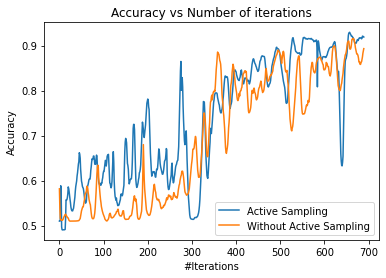

In [54]:
plt.plot(test_as1)
plt.plot(test_acc_hist1)

plt.xlabel("#Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iterations")
plt.legend(['Active Sampling', 'Without Active Sampling'], loc='lower right')
print(len(test_acc_hist1))

690


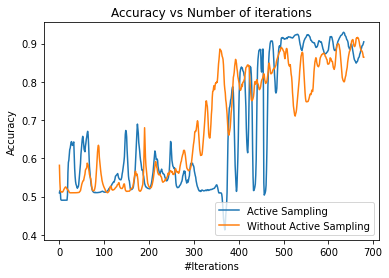

In [55]:
plt.plot(test_as[:-10])
plt.plot(test_acc_hist1[:-10])

plt.xlabel("#Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iterations")
plt.legend(['Active Sampling', 'Without Active Sampling'], loc='lower right')
print(len(test_acc_hist1))

In [30]:
print(np.max(test_acc_hist1[:900]))

0.9161828756332397


In [31]:
# test_as = [0.5332002639770508, 0.512699544429779, 0.5105224847793579, 0.5101596713066101, 0.5130624175071716, 0.5199564695358276, 0.5286647081375122, 0.5335631370544434, 0.5451741814613342, 0.5615021586418152, 0.5734760761260986, 0.5859941840171814, 0.583635687828064, 0.579463005065918, 0.5818215012550354, 0.5734760761260986, 0.5638606548309326, 0.5578737258911133, 0.5511611104011536, 0.5506168603897095, 0.5433599352836609, 0.5357401967048645, 0.5357401967048645, 0.5351959466934204, 0.53447026014328, 0.5379172563552856, 0.5404571890830994, 0.5424528121948242, 0.5475326776504517, 0.5537010431289673, 0.5486211776733398, 0.543904185295105, 0.5406386256217957, 0.5399129390716553, 0.5406386256217957, 0.5404571890830994, 0.5371915698051453, 0.5399129390716553, 0.5419085621833801, 0.5382801294326782, 0.5337445735931396, 0.5326560139656067, 0.5339259505271912, 0.532837450504303, 0.5302975177764893, 0.530116081237793, 0.5277576446533203, 0.5246734619140625, 0.5208635926246643, 0.5170537233352661, 0.5148766040802002, 0.5148766040802002, 0.5141509175300598, 0.5141509175300598, 0.5139695405960083, 0.5148766040802002, 0.5161466002464294, 0.5188679099082947, 0.5244920253753662, 0.5322932004928589, 0.5377358198165894, 0.5497097373008728, 0.5584179759025574, 0.5711175799369812, 0.5854499340057373, 0.6021407842636108, 0.611211895942688, 0.6230043768882751, 0.6255442500114441, 0.6271770596504211, 0.6242743134498596, 0.6211901307106018, 0.6086719632148743, 0.6030479073524475, 0.59325110912323, 0.594883918762207, 0.5943396091461182, 0.6115747690200806, 0.6075834631919861, 0.5872641801834106, 0.5709361433982849, 0.5575109124183655, 0.5497097373008728, 0.5422714352607727, 0.5410014390945435, 0.5361030697822571, 0.5312046408653259, 0.5273947715759277, 0.5286647081375122, 0.5332002639770508, 0.5337445735931396, 0.5350145101547241, 0.5373730063438416, 0.5406386256217957, 0.5419085621833801, 0.5420899987220764, 0.5359216332435608, 0.5342888236045837, 0.5388243794441223, 0.5428156852722168, 0.5489840507507324, 0.560413658618927, 0.5776487588882446, 0.6035921573638916, 0.6277213096618652, 0.6591073870658875, 0.6816037893295288, 0.687046468257904, 0.6841436624526978, 0.6741654276847839, 0.6748911738395691, 0.6719883680343628, 0.6614658832550049, 0.6447750329971313, 0.6219158172607422, 0.5956096053123474, 0.5805515050888062, 0.5711175799369812, 0.5580551624298096, 0.5533381700515747, 0.5515239238739014, 0.5509796738624573, 0.555152416229248, 0.5624092817306519, 0.5616835951805115, 0.553519606590271, 0.5522496104240417, 0.5489840507507324, 0.5478954911231995, 0.5478954911231995, 0.5473512411117554, 0.5458998680114746, 0.543904185295105, 0.5458998680114746, 0.5509796738624573, 0.5547895431518555, 0.5609579086303711, 0.5705732703208923, 0.5801886916160583, 0.5858127474784851, 0.5901669263839722, 0.5977866649627686, 0.6026850342750549, 0.611211895942688, 0.6171988248825073, 0.6282656192779541, 0.6324383020401001, 0.6465892791748047, 0.6531204581260681, 0.6632801294326782, 0.6719883680343628, 0.673258364200592, 0.677431046962738, 0.6794267296791077, 0.6767053604125977, 0.6701741814613342, 0.6738026142120361, 0.6728954911231995, 0.662010133266449, 0.6703555583953857, 0.6767053604125977, 0.6812409162521362, 0.687046468257904, 0.6832365989685059, 0.6881349682807922, 0.7149854898452759, 0.7403846383094788, 0.7563498020172119, 0.7581639885902405, 0.7501814365386963, 0.7521770596504211, 0.7487300634384155, 0.7325834631919861, 0.7207909822463989, 0.7122641801834106, 0.7099056839942932, 0.7071843147277832, 0.7048258185386658, 0.7035558819770813, 0.6995645761489868, 0.7011973857879639, 0.6866835951805115, 0.6797895431518555, 0.663642942905426, 0.6476777791976929, 0.6366110444068909, 0.623911440372467, 0.6099419593811035, 0.6017779111862183, 0.5961538553237915, 0.5972423553466797, 0.6021407842636108, 0.613933265209198, 0.6237300634384155, 0.6289913058280945, 0.6199201941490173, 0.6132075190544128, 0.6097605228424072, 0.6035921573638916, 0.5981494784355164, 0.5916182994842529, 0.585268497467041, 0.5745645761489868, 0.5689405202865601, 0.5636792182922363, 0.5607764720916748, 0.5605950355529785, 0.5627721548080444, 0.5682148337364197, 0.5743831396102905, 0.5834543108940125, 0.5885341167449951, 0.5901669263839722, 0.5925254225730896, 0.59325110912323, 0.5927067995071411, 0.5910740494728088, 0.5914368629455566, 0.5901669263839722, 0.5885341167449951, 0.5890783667564392, 0.5872641801834106, 0.5843613743782043, 0.5841799974441528, 0.5820028781890869, 0.5791001319885254, 0.5816400647163391, 0.5829100012779236, 0.587989866733551, 0.5927067995071411, 0.6021407842636108, 0.6153846383094788, 0.6282656192779541, 0.6262699365615845, 0.6048620939254761, 0.5930696725845337, 0.5874455571174622, 0.5847242474555969, 0.5907111763954163, 0.5970609784126282, 0.6075834631919861, 0.6177431344985962, 0.626632809638977, 0.6455007195472717, 0.6674528121948242, 0.6890420913696289, 0.6990203261375427, 0.6970247030258179, 0.6903120279312134, 0.6787010431289673, 0.6712626814842224, 0.6616473197937012, 0.6531204581260681, 0.6476777791976929, 0.6489477753639221, 0.6485849022865295, 0.6407837271690369, 0.6476777791976929, 0.668904185295105, 0.6857764720916748, 0.6995645761489868, 0.7082728743553162, 0.6955732703208923, 0.6687228083610535, 0.6416908502578735, 0.619738757610321, 0.6039550304412842, 0.5896226167678833, 0.5785558819770813, 0.587989866733551, 0.5881712436676025, 0.5981494784355164, 0.5903483033180237, 0.5584179759025574, 0.5315675139427185, 0.525943398475647, 0.5226777791976929, 0.5228592157363892, 0.5237663388252258, 0.5253991484642029, 0.524854838848114, 0.5235849022865295, 0.5239477753639221, 0.5230406522750854, 0.5219520926475525, 0.5194122195243835, 0.5186864733695984, 0.5177794098854065, 0.5177794098854065, 0.5166908502578735, 0.5163280367851257, 0.5166908502578735, 0.5170537233352661, 0.5156023502349854, 0.5136066675186157, 0.5130624175071716, 0.5119738578796387, 0.5114296078681946, 0.5123367309570312, 0.5128809809684753, 0.5143323540687561, 0.5146952271461487, 0.5143323540687561, 0.5141509175300598, 0.512155294418335, 0.511066734790802, 0.5103410482406616, 0.5099782347679138, 0.5094339847564697, 0.5090711116790771, 0.5067126154899597, 0.5045355558395386, 0.5038098692893982, 0.501632809638977, 0.5056241154670715, 0.506894052028656, 0.5094339847564697, 0.5094339847564697, 0.5094339847564697, 0.5094339847564697, 0.5094339847564697, 0.5103410482406616, 0.5125181674957275, 0.513788104057312, 0.5141509175300598, 0.5128809809684753, 0.5107039213180542, 0.5101596713066101, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5099782347679138, 0.5101596713066101, 0.5117924809455872, 0.5152394771575928, 0.5195935964584351, 0.525943398475647, 0.5322932004928589, 0.5373730063438416, 0.5380986928939819, 0.5400943160057068, 0.5391872525215149, 0.5417271256446838, 0.5491654276847839, 0.5537010431289673, 0.5649492144584656, 0.5789186954498291, 0.5968795418739319, 0.6162917017936707, 0.6431422233581543, 0.6723512411117554, 0.7048258185386658, 0.7443758845329285, 0.7663280367851257, 0.770682156085968, 0.7741291522979736, 0.7735849022865295, 0.7861030697822571, 0.7895500659942627, 0.7819303274154663, 0.782837450504303, 0.7799347043037415, 0.7822932004928589, 0.7888243794441223, 0.8000725507736206, 0.8133164048194885, 0.8271045088768005, 0.8434324860572815, 0.8563135266304016, 0.8686501979827881, 0.873367190361023, 0.8768142461776733, 0.8804426789283752, 0.8784469962120056, 0.8726415038108826, 0.8653846383094788, 0.8563135266304016, 0.8546807169914246, 0.857039213180542, 0.8633889555931091, 0.8675616979598999, 0.8641146421432495, 0.8593976497650146, 0.8544992804527283, 0.84325110912323, 0.8300072550773621, 0.8216618299484253, 0.8109579086303711, 0.8067851662635803, 0.8085994124412537, 0.8066037893295288, 0.7957184314727783, 0.7928156852722168, 0.7893686294555664, 0.7920899987220764, 0.7968069911003113, 0.8105950355529785, 0.8196662068367004, 0.8385341167449951, 0.8541364073753357, 0.8642960786819458, 0.8730043768882751, 0.8851596713066101, 0.8922351002693176, 0.9005805253982544, 0.905116081237793, 0.9087445735931396, 0.9049347043037415, 0.8675616979598999, 0.8911466002464294, 0.9022133350372314, 0.916364312171936, 0.9214441180229187, 0.9243468642234802, 0.9250725507736206, 0.9203555583953857, 0.9165456891059875, 0.9125544428825378, 0.9083817005157471, 0.907837450504303, 0.9049347043037415, 0.9011248350143433, 0.8980406522750854, 0.8951379060745239, 0.8889695405960083, 0.8862481713294983, 0.8837082982063293, 0.8797169923782349, 0.876088559627533, 0.8759071230888367, 0.8755442500114441, 0.8768142461776733, 0.8742743134498596, 0.8713715672492981, 0.8708272576332092, 0.8720972537994385, 0.8686501979827881, 0.8673802614212036, 0.8632075190544128, 0.8642960786819458, 0.8690130710601807, 0.8731857538223267, 0.8771770596504211, 0.8855224847793579, 0.8942307829856873, 0.9000362753868103, 0.9080188870429993, 0.912010133266449, 0.9129172563552856, 0.9116473197937012, 0.9100145101547241, 0.9089259505271912, 0.9040275812149048, 0.8947750329971313, 0.887699544429779, 0.881894052028656, 0.8737300634384155, 0.868105947971344, 0.8635703921318054, 0.8613933324813843, 0.8597605228424072, 0.8577648997306824, 0.8586719632148743, 0.8630261421203613, 0.8671988248825073, 0.8708272576332092, 0.875, 0.8779027462005615, 0.887155294418335, 0.8916908502578735, 0.9007619619369507, 0.9045718312263489, 0.9092888236045837, 0.9114658832550049, 0.9156386256217957, 0.9196298718452454, 0.9208998680114746, 0.9236211776733398, 0.9281567335128784, 0.9228954911231995, 0.9208998680114746, 0.9194484949111938, 0.9170899987220764, 0.916364312171936, 0.9116473197937012, 0.9060232043266296, 0.905116081237793, 0.902576208114624, 0.9031204581260681, 0.9020319581031799, 0.899854838848114, 0.8953192830085754, 0.8911466002464294, 0.8866110444068909, 0.8851596713066101, 0.8855224847793579, 0.8826197385787964, 0.8815311789512634, 0.8797169923782349, 0.876632809638977, 0.8764513731002808, 0.8786284327507019, 0.8764513731002808, 0.8748185634613037, 0.8726415038108826, 0.8684688210487366, 0.8646589517593384, 0.8539550304412842, 0.8452467322349548, 0.8407111763954163, 0.84052973985672, 0.8441581726074219, 0.8481494784355164, 0.8548620939254761, 0.8610304594039917, 0.8711901307106018, 0.8864296078681946, 0.8985849022865295, 0.9121915698051453, 0.907837450504303, 0.9042090177536011, 0.9071117639541626, 0.8955007195472717, 0.8708272576332092, 0.8485123515129089, 0.849056601524353, 0.875, 0.8955007195472717, 0.9178156852722168, 0.9283381700515747, 0.9247097373008728, 0.9190856218338013, 0.9118287563323975, 0.9043903946876526, 0.8982220888137817, 0.8938679099082947, 0.8909651637077332, 0.8893323540687561, 0.888788104057312, 0.8858853578567505, 0.8844339847564697, 0.882982611656189, 0.8858853578567505, 0.8873367309570312, 0.887699544429779, 0.8893323540687561, 0.8911466002464294, 0.8907837271690369, 0.8911466002464294, 0.8938679099082947, 0.8965892791748047, 0.8976777791976929, 0.8993105888366699, 0.9014876484870911, 0.9043903946876526, 0.9056603908538818, 0.9052975177764893, 0.9063860774040222, 0.9065675139427185, 0.9063860774040222, 0.9047532677650452, 0.9045718312263489, 0.9052975177764893, 0.9062046408653259, 0.9071117639541626, 0.9085631370544434, 0.90947026014328, 0.9096516966819763, 0.9116473197937012, 0.9134615659713745, 0.9152757525444031, 0.914731502532959, 0.9140058159828186, 0.9130986928939819, 0.9125544428825378, 0.9118287563323975, 0.9098330736160278, 0.9045718312263489, 0.9011248350143433, 0.8991291522979736, 0.8978592157363892]


Text(0.5, 1.0, '')

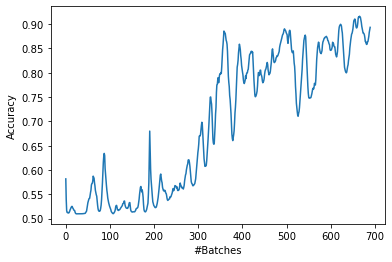

In [35]:
plt.plot(test_acc_hist1)
# plt.plot(test_as)
plt.xlabel("#Batches")
plt.ylabel("Accuracy")
plt.title("")
# plt.legend(("Without Active sampling", "Active Sampling"))

[0.6654571890830994, 0.5992984771728516, 0.33708271384239197, 0.33454281091690063, 0.33454281091690063, 0.33454281091690063, 0.33454281091690063, 0.33454281091690063, 0.33478471636772156, 0.425858736038208, 0.5032656192779541, 0.5401548147201538, 0.5397919416427612, 0.49455732107162476, 0.4397677779197693, 0.38219642639160156, 0.36683598160743713, 0.38558298349380493, 0.42210933566093445, 0.49685534834861755, 0.5922834873199463, 0.6378809809684753, 0.6415094137191772, 0.6279632449150085, 0.6331639885902405, 0.6295355558395386, 0.6024431586265564, 0.6163522005081177, 0.6196178197860718, 0.6311078667640686, 0.6450169086456299, 0.6532413959503174, 0.6649733781814575, 0.6701741814613342, 0.670053243637085, 0.6695694327354431, 0.6686018109321594, 0.667876124382019, 0.6683599352836609, 0.6679971218109131, 0.6684808731079102, 0.6683599352836609, 0.6683599352836609, 0.6695694327354431, 0.6711417436599731, 0.6721093654632568, 0.6735607385635376, 0.6746492385864258, 0.6736816763877869, 0.6729559898376465, 0.6722303032875061, 0.6718674302101135, 0.6722303032875061, 0.6712626814842224, 0.6708998680114746, 0.6706579327583313, 0.6704160571098328, 0.6706579327583313, 0.670536994934082, 0.6701741814613342, 0.6695694327354431, 0.670053243637085, 0.6686018109321594, 0.667876124382019, 0.6679971218109131, 0.6679971218109131, 0.6677551865577698, 0.667876124382019, 0.6679971218109131, 0.667876124382019, 0.6675133109092712, 0.6672714352607727, 0.6672714352607727, 0.6672714352607727, 0.6671504378318787, 0.6671504378318787, 0.6665456891059875, 0.6667876243591309, 0.6675133109092712, 0.6688437461853027, 0.6698113083839417, 0.6704160571098328, 0.6724721789360046, 0.674286425113678, 0.6757377982139587, 0.676947295665741, 0.6765844225883484, 0.6765844225883484, 0.6768262982368469, 0.6753749251365662, 0.6756168603897095, 0.6735607385635376, 0.6729559898376465, 0.6698113083839417, 0.6698113083839417, 0.6694484949111938, 0.6692065596580505, 0.6681180596351624, 0.6676342487335205, 0.667392373085022, 0.6672714352607727, 0.6661828756332397, 0.6658200025558472, 0.666303813457489, 0.6669085621833801, 0.6669085621833801, 0.6669085621833801, 0.6671504378318787, 0.6671504378318787, 0.6676342487335205, 0.6681180596351624, 0.6690856218338013, 0.6693275570869446, 0.6699322462081909, 0.6718674302101135, 0.6739235520362854, 0.6762215495109558, 0.6786405444145203, 0.6806966662406921, 0.684325098991394, 0.6884373426437378, 0.6933962106704712, 0.6973875164985657, 0.6973875164985657, 0.6920657753944397, 0.6886792182922363, 0.6852927207946777, 0.6838412880897522, 0.6837203502655029, 0.6832365989685059, 0.6833575367927551, 0.6817851662635803, 0.6809385418891907, 0.6802128553390503, 0.6797291040420532, 0.6799709796905518, 0.6808176040649414, 0.6822689771652222, 0.6810594797134399, 0.6794871687889099, 0.6790033578872681, 0.680091917514801, 0.6803337931632996, 0.6804547905921936, 0.6839622855186462, 0.6866230964660645, 0.6875907182693481, 0.6865021586418152, 0.6857764720916748, 0.6852927207946777, 0.6834784746170044, 0.6822689771652222, 0.6805757284164429, 0.6780357956886292, 0.6768262982368469, 0.6763425469398499, 0.6754958629608154, 0.6753749251365662, 0.675858736038208, 0.6761006116867065, 0.6783986687660217, 0.6788824200630188, 0.6787614822387695, 0.6777939200401306, 0.6791243553161621, 0.681180477142334, 0.682752788066864, 0.6858974099159241, 0.6868650317192078, 0.6871069073677063, 0.6877116560935974, 0.68807452917099, 0.686985969543457, 0.6871069073677063, 0.6875907182693481, 0.6873488426208496, 0.6865021586418152, 0.6872278451919556, 0.6861393451690674, 0.6851717233657837, 0.6862602829933167, 0.6883164048194885, 0.6903725266456604, 0.6871069073677063, 0.6840832233428955, 0.6817851662635803, 0.6797291040420532, 0.6779148578643799, 0.6768262982368469, 0.6762215495109558, 0.6764634847640991, 0.676947295665741, 0.6782776713371277, 0.680091917514801, 0.6808176040649414, 0.6822689771652222, 0.6834784746170044, 0.6852927207946777, 0.6867440938949585, 0.6872278451919556, 0.6858974099159241, 0.684325098991394, 0.6817851662635803, 0.6796081066131592, 0.6777939200401306, 0.6767053604125977, 0.6763425469398499, 0.6762215495109558, 0.6765844225883484, 0.6780357956886292, 0.6786405444145203, 0.6798500418663025, 0.6825109124183655, 0.6842041611671448, 0.682752788066864, 0.6819061636924744, 0.681180477142334, 0.6810594797134399, 0.6814223527908325, 0.6820271015167236, 0.682752788066864, 0.6828737258911133, 0.6842041611671448, 0.6850507855415344, 0.684325098991394, 0.6850507855415344, 0.6852927207946777, 0.6857764720916748, 0.686985969543457, 0.6868650317192078, 0.6868650317192078, 0.6862602829933167, 0.6862602829933167, 0.6866230964660645, 0.6871069073677063, 0.6873488426208496, 0.6888002157211304, 0.6900096535682678, 0.6906144022941589, 0.6915820240974426, 0.6926705241203308, 0.6946057081222534, 0.6970247030258179, 0.6988388895988464, 0.7027092576026917, 0.706095814704895, 0.7073052525520325, 0.7087566256523132, 0.7106918096542358, 0.7135945558547974, 0.7194001078605652, 0.7242380380630493, 0.7275036573410034, 0.7357280850410461, 0.7454039454460144, 0.758466362953186, 0.7737058401107788, 0.7826560139656067, 0.7879777550697327, 0.789671003818512, 0.7865263819694519, 0.7820512652397156, 0.7793903946876526, 0.7816884517669678, 0.7882196307182312, 0.7930575609207153, 0.7935413718223572, 0.7891872525215149, 0.7830188870429993, 0.7785437703132629, 0.7726173400878906, 0.7699564695358276, 0.7682631611824036, 0.7710449695587158, 0.7744315266609192, 0.7679003477096558, 0.7675374746322632, 0.7670537233352661, 0.7670537233352661, 0.7654813528060913, 0.7646347284317017, 0.7583454251289368, 0.7527818083763123, 0.748911440372467, 0.744194507598877, 0.7422593235969543, 0.7437106966972351, 0.743105947971344, 0.7423802614212036, 0.7467343807220459, 0.7556845545768738, 0.7681422233581543, 0.7728592157363892, 0.7773342728614807, 0.792331874370575, 0.8092646598815918, 0.823052704334259, 0.8280116319656372, 0.8328495621681213, 0.8300677537918091, 0.8280116319656372, 0.8236574530601501, 0.8139815926551819, 0.8090227246284485, 0.805152416229248, 0.7963231801986694, 0.7865263819694519, 0.7814465165138245, 0.7805998921394348, 0.7820512652397156, 0.7810837030410767, 0.7851959466934204, 0.787010133266449, 0.7894291281700134, 0.7930575609207153, 0.7999516129493713, 0.8089017868041992, 0.8196662068367004, 0.828374445438385, 0.8300677537918091, 0.8369618058204651, 0.8357523083686829, 0.8396226167678833, 0.8402273654937744, 0.8424044251441956, 0.8534107208251953, 0.8713110685348511, 0.8806241154670715, 0.8873971700668335, 0.8904209136962891, 0.8942912220954895, 0.8918722867965698, 0.8890904784202576, 0.8927189111709595, 0.8910256624221802, 0.8906627893447876, 0.8906627893447876, 0.8941702842712402, 0.8963473439216614, 0.9014272093772888, 0.910498321056366, 0.9160619378089905, 0.9179971218109131, 0.9204160571098328, 0.9234397411346436, 0.9235607385635376, 0.9190856218338013, 0.9149733781814575, 0.907837450504303, 0.8984034657478333, 0.8923560976982117, 0.8886066675186157, 0.8870343565940857, 0.8847363591194153, 0.8834059238433838, 0.8824383020401001, 0.8837687373161316, 0.8847363591194153, 0.887155294418335, 0.8872762322425842, 0.8905418515205383, 0.8910256624221802, 0.8894532918930054, 0.888727605342865, 0.8811078667640686, 0.8703435063362122, 0.8566763401031494, 0.8420416116714478, 0.8335752487182617, 0.8338171243667603, 0.8333333134651184, 0.836840808391571, 0.8399854898452759, 0.8430091738700867, 0.84482342004776, 0.8444605469703674, 0.8419206738471985, 0.8434929847717285, 0.8478471040725708, 0.8555877804756165, 0.8651427030563354, 0.8717948794364929, 0.8769956231117249, 0.8798984289169312, 0.8786889314651489, 0.8777213096618652, 0.8771166205406189, 0.8774794340133667, 0.8789308071136475, 0.8813498020172119, 0.8796564936637878, 0.8751814365386963, 0.8651427030563354, 0.8611514568328857, 0.8597000241279602, 0.8582486510276794, 0.8528059720993042, 0.8492984771728516, 0.8424044251441956, 0.8404693007469177, 0.8386550545692444, 0.8417997360229492, 0.8482099771499634, 0.8522012829780579, 0.8547411561012268, 0.8574020266532898, 0.8640542030334473, 0.8675616979598999, 0.8676826357841492, 0.8692549467086792, 0.8721576929092407, 0.8740928769111633, 0.875060498714447, 0.8734881281852722, 0.8785679936408997, 0.8800193667411804, 0.8826802372932434, 0.8867924809455872, 0.8907837271690369, 0.8941702842712402, 0.8969520926475525, 0.9004595875740051, 0.9046927690505981, 0.9061441421508789, 0.9075955748558044, 0.9092888236045837, 0.910982072353363, 0.9119496941566467, 0.9137638807296753, 0.9164247512817383, 0.9181180596351624, 0.9202951192855835, 0.920536994934082, 0.9227140545845032, 0.9240444898605347, 0.9261006116867065, 0.9252539873123169, 0.924770176410675, 0.9241654276847839, 0.9257377982139587, 0.9265844225883484, 0.9202951192855835, 0.9048137664794922, 0.8961054682731628, 0.8973149657249451, 0.9074745774269104, 0.918964684009552, 0.9235607385635376, 0.9212626814842224, 0.9132801294326782, 0.9083212614059448, 0.9017900228500366, 0.9017900228500366, 0.9007015228271484, 0.9010643362998962, 0.9020319581031799, 0.9020319581031799, 0.9032413959503174, 0.9043299555778503, 0.9045718312263489, 0.9057813286781311, 0.9049347043037415, 0.9038461446762085, 0.9044508934020996, 0.9034833312034607, 0.8986454010009766, 0.8970730304718018, 0.8922351002693176, 0.8912675380706787, 0.8873971700668335, 0.8837687373161316, 0.8815916776657104, 0.8808659911155701, 0.8796564936637878, 0.8794146180152893, 0.8779632449150085, 0.8790517449378967, 0.8798984289169312, 0.881954550743103, 0.8835268616676331, 0.8842525482177734, 0.8841316103935242, 0.8796564936637878, 0.8767537474632263, 0.8763909339904785, 0.8755442500114441, 0.8739719390869141, 0.8721576929092407, 0.8716739416122437, 0.8719158172607422, 0.8737300634384155, 0.8756651878356934, 0.8788098692893982, 0.8798984289169312, 0.8805031180381775, 0.8811078667640686, 0.8825592398643494, 0.8850991725921631, 0.8869134187698364, 0.8893323540687561, 0.8912675380706787, 0.8923560976982117, 0.892960786819458, 0.8918722867965698, 0.8870343565940857, 0.8842525482177734, 0.881833553314209, 0.8800193667411804, 0.8783260583877563, 0.8761489987373352, 0.8742138147354126, 0.872399628162384, 0.8713110685348511, 0.8690130710601807, 0.8696178197860718, 0.8709482550621033, 0.8751814365386963, 0.8778423070907593, 0.8812288045883179, 0.8847363591194153, 0.8899371027946472, 0.8925979733467102, 0.8947750329971313, 0.8968311548233032, 0.8953797817230225, 0.8927189111709595, 0.8906627893447876, 0.8892114162445068, 0.8905418515205383, 0.8934445977210999, 0.8950169086456299, 0.8976777791976929, 0.8980406522750854, 0.895621657371521, 0.8953797817230225, 0.894049346446991, 0.8964683413505554, 0.896710216999054, 0.8968311548233032, 0.8987663388252258, 0.9003386497497559, 0.9042090177536011, 0.9097726345062256, 0.9153362512588501, 0.920053243637085, 0.920053243637085, 0.9184808731079102, 0.9166666865348816, 0.9141267538070679, 0.9125544428825378, 0.9125544428825378, 0.9108611345291138, 0.9102563858032227, 0.9075955748558044, 0.9057813286781311, 0.9038461446762085, 0.9019109606742859, 0.9010643362998962, 0.9017900228500366, 0.9010643362998962, 0.899854838848114, 0.9000967741012573, 0.9027576446533203, 0.9038461446762085, 0.902515709400177, 0.8992501497268677, 0.898282527923584, 0.8992501497268677, 0.8980406522750854, 0.8958635926246643, 0.8951379060745239, 0.8936864733695984, 0.8953797817230225, 0.8958635926246643, 0.8961054682731628, 0.8965892791748047, 0.896710216999054, 0.8946540951728821, 0.892960786819458, 0.8922351002693176, 0.8927189111709595, 0.894049346446991, 0.8948959708213806, 0.8975568413734436, 0.9014272093772888, 0.9050556421279907, 0.9077165126800537, 0.9111030697822571, 0.9140058159828186, 0.9159409999847412, 0.9150943160057068, 0.9146105647087097, 0.9132801294326782, 0.9137638807296753, 0.9177551865577698, 0.9221093654632568, 0.9268262982368469, 0.9304547905921936, 0.9331156015396118, 0.9346879720687866, 0.9323899149894714, 0.9305757284164429, 0.9257377982139587, 0.9223512411117554, 0.9196903705596924, 0.9169085621833801, 0.9148524403572083, 0.9152153134346008, 0.9165456891059875, 0.9169085621833801, 0.9177551865577698, 0.9146105647087097, 0.9117078185081482, 0.9091678857803345, 0.90674889087677, 0.9060232043266296, 0.9073536396026611, 0.910498321056366, 0.9101354479789734, 0.9126753807067871, 0.9140058159828186, 0.9164247512817383, 0.9182389974594116, 0.9159409999847412, 0.9152153134346008, 0.910982072353363, 0.9055394530296326, 0.899854838848114, 0.8961054682731628, 0.8934445977210999, 0.8910256624221802, 0.8878809809684753, 0.8854620456695557, 0.884494423866272, 0.8824383020401001, 0.8814707398414612, 0.8808659911155701, 0.8794146180152893, 0.8791727423667908, 0.8789308071136475, 0.87929368019104, 0.8786889314651489, 0.877600371837616, 0.8783260583877563, 0.8794146180152893, 0.8812288045883179, 0.8847363591194153, 0.8870343565940857, 0.8894532918930054, 0.891388475894928, 0.8932027220726013, 0.8948959708213806, 0.8955007195472717, 0.8976777791976929, 0.9004595875740051, 0.9010643362998962, 0.8997339010238647, 0.8996129631996155, 0.9016690850257874, 0.90360426902771, 0.9065070152282715, 0.9080793261528015, 0.9073536396026611, 0.90517657995224, 0.9011852741241455, 0.8979197144508362, 0.8950169086456299, 0.8952588438987732, 0.8951379060745239, 0.8951379060745239, 0.8934445977210999, 0.8912675380706787, 0.889816164970398, 0.8872762322425842, 0.8864296078681946, 0.8849782347679138, 0.8842525482177734, 0.8867924809455872, 0.888727605342865, 0.8896952271461487, 0.8921141624450684, 0.8947750329971313, 0.8968311548233032, 0.9021528959274292, 0.9054184556007385, 0.9080793261528015, 0.9111030697822571, 0.9140058159828186, 0.9158200025558472, 0.917876124382019, 0.9217464923858643, 0.9261006116867065, 0.9270682334899902, 0.9275519847869873, 0.9282776713371277, 0.9282776713371277, 0.928519606590271, 0.9291243553161621, 0.930091917514801, 0.9313014149665833, 0.9322689771652222, 0.9313014149665833, 0.9287614822387695, 0.925858736038208, 0.9234397411346436, 0.9186018109321594, 0.9142476916313171, 0.9089259505271912, 0.90360426902771, 0.8987663388252258, 0.8952588438987732, 0.8985244035720825, 0.8968311548233032, 0.8958635926246643, 0.8976777791976929, 0.9000967741012573, 0.8988872766494751, 0.8977987170219421, 0.8953797817230225, 0.8917513489723206, 0.8890904784202576, 0.8882438540458679, 0.8854620456695557, 0.8794146180152893, 0.8717948794364929, 0.8662312626838684, 0.8610304594039917, 0.856918215751648, 0.8529269695281982, 0.8486937880516052, 0.8472423553466797, 0.8461538553237915, 0.8459119200706482, 0.8483309149742126, 0.8494194746017456, 0.8536526560783386, 0.8572810888290405, 0.8618771433830261, 0.8685292601585388, 0.8783260583877563, 0.8899371027946472, 0.8969520926475525, 0.90517657995224, 0.913159191608429, 0.9204160571098328, 0.9251330494880676, 0.9302128553390503, 0.934325098991394, 0.9346879720687866, 0.9357764720916748, 0.9360184073448181, 0.9368650317192078, 0.9385582804679871, 0.9409772753715515, 0.9424286484718323, 0.9430333971977234, 0.9436381459236145, 0.9436381459236145, 0.9431543350219727, 0.943880021572113, 0.944847583770752, 0.9455732703208923, 0.944968581199646, 0.9442428350448608, 0.9430333971977234, 0.9418238997459412, 0.9413400888442993, 0.9410982131958008, 0.9407353401184082, 0.9352927207946777, 0.9257377982139587, 0.9187228083610535, 0.9125544428825378, 0.9086840748786926, 0.9073536396026611, 0.906265139579773, 0.9073536396026611, 0.9061441421508789, 0.9037252068519592, 0.9028785824775696, 0.9011852741241455, 0.9027576446533203, 0.9043299555778503, 0.9040880799293518, 0.9010643362998962, 0.899854838848114, 0.899854838848114, 0.9000967741012573, 0.9026366472244263, 0.9049347043037415, 0.9084421992301941, 0.9119496941566467, 0.9154571890830994, 0.9181180596351624, 0.9213836193084717, 0.9267053604125977, 0.9299709796905518, 0.932752788066864, 0.9350507855415344, 0.9345670342445374, 0.9367440938949585, 0.9373488426208496, 0.9390420913696289, 0.9390420913696289, 0.9391630291938782, 0.9402515888214111, 0.9406144022941589, 0.9409772753715515, 0.94121915102005, 0.9424286484718323, 0.9425495862960815, 0.9437590837478638, 0.944968581199646, 0.944847583770752, 0.9464199542999268, 0.9454523324966431, 0.9415820240974426, 0.9367440938949585, 0.9345670342445374, 0.931664228439331, 0.9275519847869873, 0.9239235520362854, 0.9202951192855835, 0.9175133109092712, 0.9167876243591309, 0.9182389974594116, 0.9183599352836609, 0.9186018109321594, 0.9188437461853027, 0.916303813457489, 0.9115868210792542, 0.9084421992301941, 0.9072327017784119, 0.9090469479560852, 0.9123125076293945, 0.9164247512817383, 0.917876124382019, 0.9201741814613342, 0.9224721789360046, 0.9219883680343628, 0.9206579327583313, 0.9198113083839417, 0.918964684009552, 0.9183599352836609, 0.9181180596351624, 0.9165456891059875, 0.914731502532959, 0.9129172563552856, 0.9117078185081482, 0.9086840748786926, 0.9075955748558044, 0.9071117639541626, 0.9077165126800537, 0.9101354479789734, 0.9130381941795349, 0.9146105647087097, 0.9165456891059875, 0.9199322462081909, 0.9221093654632568, 0.9236816763877869, 0.9267053604125977, 0.9294871687889099, 0.9340832233428955, 0.9367440938949585, 0.9391630291938782, 0.9404934644699097, 0.9408563375473022, 0.942307710647583, 0.9427914619445801, 0.9442428350448608, 0.9443638324737549, 0.9443638324737549, 0.9442428350448608, 0.9432752728462219, 0.9426705241203308, 0.9419448375701904, 0.9417029619216919, 0.9430333971977234, 0.9430333971977234, 0.9430333971977234, 0.9435171484947205, 0.9424286484718323, 0.9398887157440186, 0.9373488426208496, 0.9365021586418152, 0.9356555342674255, 0.9360184073448181, 0.9372278451919556, 0.9383164048194885, 0.9397677779197693, 0.9429124593734741, 0.944847583770752, 0.9459361433982849, 0.9489598274230957, 0.9499274492263794, 0.9502902626991272, 0.9500483870506287, 0.951741635799408, 0.953434944152832, 0.9552491307258606, 0.9551281929016113, 0.9545234441757202, 0.9540396928787231, 0.954402506351471, 0.9541606307029724, 0.9548863172531128, 0.9550072550773621, 0.9557329416275024, 0.9552491307258606, 0.9542815685272217, 0.9529511332511902, 0.9511368870735168, 0.949201762676239, 0.9462989568710327, 0.9430333971977234, 0.9397677779197693, 0.9381954669952393, 0.936985969543457, 0.9373488426208496, 0.9385582804679871, 0.9385582804679871, 0.9395259022712708, 0.9403725266456604, 0.9432752728462219, 0.943880021572113, 0.9447266459465027, 0.9471456408500671, 0.9494436383247375, 0.9500483870506287, 0.9506531357765198, 0.9516206979751587, 0.9512578845024109, 0.9511368870735168, 0.9495645761489868, 0.9498065114021301, 0.9499274492263794, 0.9506531357765198, 0.9528301954269409, 0.9523463845252991, 0.9518625736236572, 0.9514997601509094, 0.951741635799408]
​

In [33]:
print(datetime.now())

2022-05-10 03:02:31.560571


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

def myfunc(x):
    if x[0] > x[1]:
        return 1
    return 0

y_pred = best_model.predict(scaled_x_test)
# print(yas_pred)
# yas_pred = np.argmax(yas_pred)
# print(yas_pred)

# print(y_test)
for i in range(len(y_pred)):
#     print(y_pred[i])
    y_pred[i] = myfunc(y_pred[i])
    y_test[i] = myfunc(y_test[i])
# print(y_pred)
print(classification_report(y_test.T[0], y_pred.T[0]))
# print(y_test, y_pred)
print(confusion_matrix(y_test.T[0], y_pred.T[0]))
# print(y_pred.T[0])

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      2809
         1.0       0.95      0.88      0.91      2703

    accuracy                           0.92      5512
   macro avg       0.92      0.92      0.92      5512
weighted avg       0.92      0.92      0.92      5512

[[2681  128]
 [ 334 2369]]


In [51]:
print(test_acc_hist1)


[0.5816400647163391, 0.538642942905426, 0.5161466002464294, 0.512699544429779, 0.5125181674957275, 0.5116110444068909, 0.5123367309570312, 0.5117924809455872, 0.5134252309799194, 0.5156023502349854, 0.5186864733695984, 0.5203192830085754, 0.5228592157363892, 0.5243105888366699, 0.5252177119255066, 0.5235849022865295, 0.5214078426361084, 0.5201379060745239, 0.5175979733467102, 0.5172351002693176, 0.5166908502578735, 0.5132438540458679, 0.511066734790802, 0.5101596713066101, 0.5097967982292175, 0.5097967982292175, 0.5097967982292175, 0.5099782347679138, 0.5099782347679138, 0.5097967982292175, 0.5097967982292175, 0.5097967982292175, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5096153616905212, 0.5097967982292175, 0.5099782347679138, 0.5101596713066101, 0.5101596713066101, 0.5101596713066101, 0.5103410482406616, 0.5105224847793579, 0.5105224847793579, 0.5108853578567505, 0.5125181674957275, 0.513788104057312, 0.5154209136962891, 0.5217706561088562, 0.5268505215644836, 0.5